In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.activations import linear, relu, sigmoid


from keras.datasets import mnist



2024-06-17 10:35:51.390180: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/damanr/Desktop/myprojectA/lib/python3.8/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
print(f'The shape of the training example features (X_train): {X_train.shape}')
print(f'The shape of the training example labels   (y_train): {y_train.shape}', end = '\n\n')

print(f'The shape of the test example features (X_test): {X_test.shape}')
print(f'The shape of the test example labels   (y_test): {y_test.shape}')



The shape of the training example features (X_train): (60000, 28, 28)
The shape of the training example labels   (y_train): (60000,)

The shape of the test example features (X_test): (10000, 28, 28)
The shape of the test example labels   (y_test): (10000,)


In [4]:
# Create a cross validation set from the training data to assist in model architecture selection and hyperparameter tuning
cross_validation_size = 10000

X_cv, y_cv = X_train[len(X_train) - cross_validation_size:] , y_train[len(y_train) - cross_validation_size:]
X_train , y_train = X_train[:len(X_train) - cross_validation_size] , y_train[:len(y_train) - cross_validation_size]

print(f'The shape of the validation set features (X_cv): {X_cv.shape}')
print(f'The shape of the validation set labels   (y_cv): {y_cv.shape}', end = '\n\n')

print(f'New shape of the training example features (X_train): {X_train.shape}')
print(f'New shape of the training example labels   (y_train): {y_train.shape}', end = '\n\n')



The shape of the validation set features (X_cv): (10000, 28, 28)
The shape of the validation set labels   (y_cv): (10000,)

New shape of the training example features (X_train): (50000, 28, 28)
New shape of the training example labels   (y_train): (50000,)



In [5]:
#Visualize data structure
print('First 3 Training Examples',X_train[:3],sep = '\n',end = '\n\n\n')
print('Target Labels',y_train[:3],sep = '\n')

First 3 Training Examples
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]


Target Labels
[5 0 4]


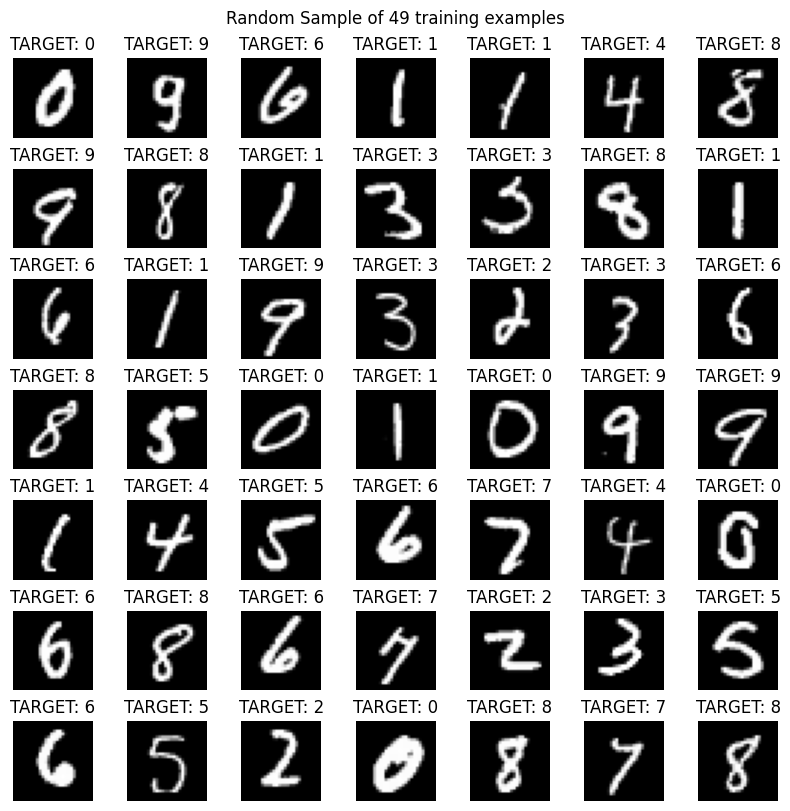

In [6]:
# View a random sampling of data
rows = 7
columns = 7 


random_indices = np.random.choice(a = len(X_train) , size = rows * columns, replace = False)

fig, axes = plt.subplots(rows,columns, constrained_layout = True)

fig.set_size_inches(8,8,forward = True)
fig.set_dpi(100)


train_count = 0
for i in range(7):
    for j in range(7):
        axes[i,j].imshow(X_train[random_indices[train_count]], cmap = 'gray')
        axes[i,j].set_title(f'TARGET: {y_train[random_indices[train_count]]}')
        axes[i,j].axis('off')
        train_count+=1

fig.suptitle(f'Random Sample of {rows * columns} training examples')

plt.show()
        

In [7]:
# Convert 28 x 28 grids of pixes to 1-D array holding sequential pixel intensities
X_train = X_train.reshape(-1,X_train.shape[1] * X_train.shape[2])
X_cv = X_cv.reshape(-1,X_cv.shape[1] * X_cv.shape[2])

X_test = X_test.reshape(-1,X_test.shape[1] * X_test.shape[2])

print(f'Finalized model input feature shape for X_train: {X_train.shape}')
print(f'Finalized model input feature shape for X_cv: {X_cv.shape}')
print(f'Finalized model input feature shape for X_test: {X_test.shape}')

Finalized model input feature shape for X_train: (50000, 784)
Finalized model input feature shape for X_cv: (10000, 784)
Finalized model input feature shape for X_test: (10000, 784)


## Creating Baseline Model 
It may be interesting to create a weak learner model that is essentially logistic regression. 
I will achieve this by creating a basic neural network with NO hidden layers, performing a classic logistic regression problem. 
This will act as a baseline to improve from. 

Performance metrics that will be analyzed:
1. Cost Function (Error Misclassified)
2. F_1 Score
   

In [33]:
baseline_model = Sequential([
    tf.keras.Input(shape = (X_train.shape[1])),
    Dense(units = 10, activation = 'linear', name = 'baseline_output')
], name = 'baseline_model')

In [34]:
baseline_model.summary()

Model: "baseline_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 baseline_output (Dense)     (None, 10)                7850      
                                                                 
Total params: 7850 (30.66 KB)
Trainable params: 7850 (30.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [35]:
baseline_model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
)

# batch_size was increase to allow for slightly faster computation speed per epoch
epoch_progress = baseline_model.fit(X_train, y_train, epochs = 150,verbose = 1,batch_size = 240)

Epoch 1/150
209/209 [==============================] - 0s 1ms/step - loss: 74.2550
Epoch 2/150
209/209 [==============================] - 0s 1ms/step - loss: 21.8937
Epoch 3/150
209/209 [==============================] - 0s 1ms/step - loss: 13.9823
Epoch 4/150
209/209 [==============================] - 0s 1ms/step - loss: 10.8807
Epoch 5/150
209/209 [==============================] - 0s 1ms/step - loss: 9.1598
Epoch 6/150
209/209 [==============================] - 0s 1ms/step - loss: 8.0396
Epoch 7/150
209/209 [==============================] - 0s 1ms/step - loss: 7.2266
Epoch 8/150
209/209 [==============================] - 0s 1ms/step - loss: 6.6172
Epoch 9/150
209/209 [==============================] - 0s 1ms/step - loss: 6.1361
Epoch 10/150
209/209 [==============================] - 0s 1ms/step - loss: 5.7299
Epoch 11/150
209/209 [==============================] - 0s 1ms/step - loss: 5.3856
Epoch 12/150
209/209 [==============================] - 0s 1ms/step - loss: 5.0718
Epoch 13/

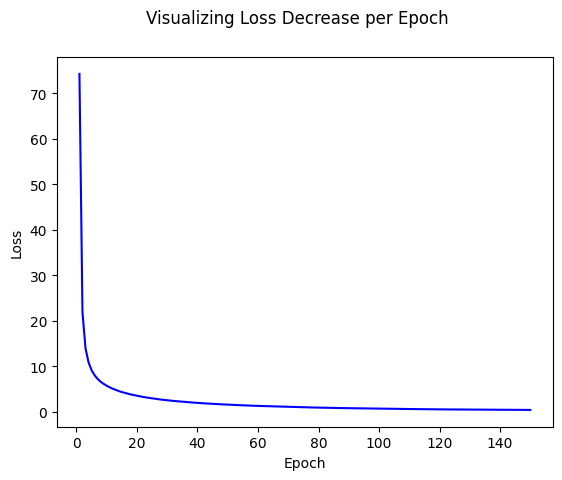

In [39]:
# Plot training curve to ensure accurate decrease of loss per epoch.
# Done to avoid divergence of gradient descent
losses = epoch_progress.history['loss']

plt.close('all')
fig, ax = plt.subplots()

fig.suptitle('Visualizing Loss Decrease per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.plot(range(1,len(losses)+1), losses, color = 'blue')


The Loss curve above shows signs of continuous decrease, confirming that an appropriate learning rate has been choosen for the baseline model.

NOTE: For the baseline model, a manual grid search approach will be carried out to optimize the parameters. For the later models a more efficient library will be used for hyperparameter tuning. 

In [55]:
# Compute accuracy of model given the cross-validation set
def compute_accuracy(model, X_cv, y_cv):
    # convert raw logit results from output layer into a probability distribution
    results = tf.nn.softmax(model.predict(X_cv))
    # Find largest probability class and have model classify it as final prediction
    preds = np.argmax(results, axis = 1)
    correct = sum(prediction == target for prediction , target in zip(preds,y_cv))
    accuracy = correct / y_cv.shape[0]
    print(f'Accuracy of {model.name} = {accuracy}')
    return accuracy

def compute_F1_score(model, X_cv, y_cv):
    num_classes = 10
    results = tf.nn.softmax(model.predict(X_cv))
    y_pred = np.argmax(results, axis = 1)
    # Step 1: Create confusion matrix
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)
    for true, pred in zip(y_cv, y_pred):
        confusion_matrix[true][pred] += 1

    # Initialize variables for macro and micro calculations
    precision_per_class = []
    recall_per_class = []
    TP = 0
    FP = 0
    FN = 0

    for k in range(num_classes):
        TP_k = confusion_matrix[k][k]
        FP_k = np.sum(confusion_matrix[:, k]) - TP_k
        FN_k = np.sum(confusion_matrix[k, :]) - TP_k

        precision_k = TP_k / (TP_k + FP_k) if (TP_k + FP_k) > 0 else 0
        recall_k = TP_k / (TP_k + FN_k) if (TP_k + FN_k) > 0 else 0

        precision_per_class.append(precision_k)
        recall_per_class.append(recall_k)

        TP += TP_k
        FP += FP_k
        FN += FN_k

    # Macro-Averaged Precision and Recall
    macro_precision = np.mean(precision_per_class)
    macro_recall = np.mean(recall_per_class)

    # Micro-Averaged Precision and Recall
    micro_precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    micro_recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    # F1-Score
    F_1 = 1/ (((1/ np.array(precision_per_class)) + (1 / np.array(recall_per_class))) * 0.5)

    return {
        "precision_per_class": precision_per_class,
        "recall_per_class": recall_per_class,
        "macro_precision": macro_precision,
        "macro_recall": macro_recall,
        "micro_precision": micro_precision,
        "micro_recall": micro_recall,
        "F1_score": F_1,
        "average_F1_score": np.mean(F_1)
    }

            
    



In [56]:
compute_accuracy(baseline_model, X_cv, y_cv)
        

313/313 [==============================] - 0s 751us/step
Accuracy of baseline_model = 0.897


0.897

In [57]:
compute_F1_score(baseline_model, X_cv, y_cv)

313/313 [==============================] - 0s 775us/step


{'precision_per_class': [0.9351944167497508,
  0.9621570482497634,
  0.8411386593204775,
  0.8827655310621243,
  0.8881322957198443,
  0.8074534161490683,
  0.9494623655913978,
  0.928110599078341,
  0.869120654396728,
  0.9064665127020786],
 'recall_per_class': [0.9465186680121089,
  0.9558270676691729,
  0.9252525252525252,
  0.8553398058252427,
  0.9287894201424212,
  0.8524590163934426,
  0.9131334022750776,
  0.9238532110091743,
  0.8424182358771061,
  0.8168574401664932],
 'macro_precision': 0.8970001499019574,
 'macro_recall': 0.8960448792622764,
 'micro_precision': 0.897,
 'micro_recall': 0.897,
 'F1_score': array([0.94082247, 0.95898161, 0.88119288, 0.86883629, 0.90800597,
        0.82934609, 0.9309436 , 0.92597701, 0.85556115, 0.85933224]),
 'average_F1_score': 0.895899930538531}